<a href="https://colab.research.google.com/github/AviRahimov/AMFLU_Assignment1/blob/main/Advanced_Models_For_Language_Understanding_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-no-target/test_no_target.csv
/kaggle/input/train-df/train.csv


# 🔹 Assignment 1: Seq2Seq Model for Sentence Unshuffling
In this assignment, you'll implement a basic **Sequence-to-Sequence (Seq2Seq)** neural network using PyTorch.

### 🎯 **Your goal:**
Given a sentence whose words have been shuffled randomly, your model must reconstruct the original sentence.

**Example:**

| Input (shuffled) | Output (original) |
|-----------------|------------------|
| `mat the on sat cat The` | `The cat sat on the mat` |

## 🔹 Why this task?
This simple yet non-trivial task demonstrates how language models learn word-order and syntactic structures.
From a psycholinguistic viewpoint, sentence reconstruction taps into:

- **Working memory**: The model must hold multiple words and reorder them meaningfully.
- **Syntax and semantics**: Reordering depends on syntactic constraints and semantic coherence.

## 🔹 Quick Summary of PyTorch Workflow

The general workflow when working with on deep learning with PyTorch usually involves these steps:

1. **Prepare your data**:
    - Define your dataset by subclassing `torch.utils.data.Dataset`.
    - Use a `DataLoader` to iterate efficiently over the dataset in batches.
    - Tokenization - select tokenization method and tokenize your data.

2. **Define your model**:
    - Create a model class by subclassing `nn.Module`.
    - Define model layers in `__init__`.
    - Define how data flows through the layers in the `forward()` method.


3. **Training**:
    - Select an appropriate loss function (`nn.CrossEntropyLoss`, `nn.MSELoss`, etc.).
    - Choose an optimizer (`optim.Adam`, `optim.SGD`, etc.).
    - **Training Loop** -- For each batch:
        1. Pass input data through your model to produce predictions (logits).
        2. Compute the loss w.r.t. the gold label (target).
        3. Perform backpropagation (`loss.backward()`) to calculate gradients of all model parameters.
        4. Update the model parameters with your optimizer (`optimizer.step()`).
        5. Reset gradients (`optimizer.zero_grad()`).

This structured workflow helps streamline model development and makes training neural networks clear and efficient.

This notebook will walk you through this process - you need to learn it and the complete the missing code segment marked with a `#TODO` comment.

## 🔹 Step 0: One-time Preparations

### Step 0.1: Install Python Dependencies

In [5]:
%pip install torch pandas scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

### Step 0.2: Download the Dataset
Download the provided dataset file (`train.csv`) from the following link:

[train.csv](https://drive.google.com/file/d/1eHBj_mdKjPfj_NuXy0zCG5IkQMJLGpPM/view?usp=sharing)

Then upload the file to your Colab notebook or Jupyter environment.

## 🔹 Step 1: Prepare Data

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.model_selection import train_test_split

random_seed = 123
random.seed(random_seed)
torch.manual_seed(random_seed)

df = pd.read_csv('/kaggle/input/train-df/train.csv')
df.head()

,Unnamed: 0,input_sentence,target_sentence
0,0,to think need we about. That's something,That's something we need to think about.
1,1,is mountains. the up moon coming over The,The moon is coming up over the mountains.
2,2,committee. the The through Congressmen bill ra...,The Congressmen rammed the bill through commit...
3,3,careful late I'll to never again. be be,I'll be careful never to be late again.
4,4,"please."" gifts, ""No The said, invitation","The invitation said, ""No gifts, please."""


In [2]:
train_df, dev_df = train_test_split(df, test_size=0.1, random_state=42)
print(f"Training examples: {len(train_df)}")
print(f"Development examples: {len(dev_df)}")

Training examples: 31500
Development examples: 3500


#### Pedagogical Note: **Why do we split train data into training and development (dev) sets?**

When developing machine learning models, we want to ensure our model not only performs well on the data it has seen during training but also generalizes effectively to **new, unseen data**.

- **Training set**:  
  Used by the model to learn patterns. This is the data your model sees repeatedly during the training process.

- **Development (dev) set** *(also known as validation set)*:  
  Used to evaluate the model's performance on unseen examples during training. By checking the model periodically against the dev set, we can identify and prevent **overfitting**—when the model performs excellently on training data but poorly on new examples.

Thus, by splitting the data, we ensure our model truly learns generalizable patterns rather than memorizing the specific examples it trained on.


In [3]:
# Handle Vocabulary and Tokenization
from collections import Counter

def tokenize(sentence):
    return sentence.lower().split()

counter = Counter()
for sentence in train_df['input_sentence']:
    counter.update(tokenize(sentence))

# Special Tokens
PAD = '<PAD>'
SOS = '<SOS>'
EOS = '<EOS>'
UNK = '<UNK>'   # to handle out-of-vocabulary words

words = [PAD, SOS, EOS, UNK] + [w for w, c in counter.items() if c >= 2]
# we maintain mapping between words (vocabulary entries) and their ids
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in word2idx.items()}

vocab_size = len(word2idx)
print(f"Vocabulary size: {vocab_size}")

def encode_sentence(sentence: str, word2idx, max_len):
    # Replace sentence string with a fixed-length list of ints (token_ids with padding)
    tokens = tokenize(sentence)
    token_ids = [word2idx.get(w, word2idx[UNK]) for w in tokens]
    token_ids = token_ids[:max_len-1]
    token_ids.append(word2idx[EOS])
    padding = [word2idx[PAD]] * (max_len - len(token_ids))
    return token_ids + padding

Vocabulary size: 8531


In [4]:
# Custom Dataset class for sentence-to-sentence mapping
class SentenceDataset(torch.utils.data.Dataset):
    def __init__(self, df, word2idx, max_len):
        # Store input and target sentences as lists of strings
        self.input_sentences = df['input_sentence'].tolist()
        self.target_sentences = df['target_sentence'].tolist()
        self.word2idx = word2idx  # mapping from word to index
        self.max_len = max_len    # maximum length of sentence (for padding)

    def __len__(self):
        # Return number of examples in the dataset
        return len(self.input_sentences)

    def __getitem__(self, idx):
        # Encode both input and target sentences to fixed-length tensors of token IDs
        src = encode_sentence(self.input_sentences[idx], self.word2idx, self.max_len)
        trg = encode_sentence(self.target_sentences[idx], self.word2idx, self.max_len)
        return torch.tensor(src), torch.tensor(trg)  # return as PyTorch tensors

# Define batch size and maximum sentence length
batch_size = 32
max_len = 50  # All sequences will be padded/truncated to this length

# Create training dataset and dataloader
train_dataset = SentenceDataset(train_df, word2idx, max_len)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# DataLoader loads batches from the dataset and optionally shuffles them

# Create development (validation) dataset and dataloader
dev_dataset = SentenceDataset(dev_df, word2idx, max_len)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=batch_size
)


In [5]:
# Get one batch of (src, trg) from the DataLoader
src_batch, trg_batch = next(iter(train_loader))

# Print their shapes
print("src_batch.shape =", src_batch.shape)
print("trg_batch.shape =", trg_batch.shape)

src_batch.shape = torch.Size([32, 50])
trg_batch.shape = torch.Size([32, 50])


## PyTorch Quick Reference

Since this is your first encounter with PyTorch in the course, here's a short summary of essential PyTorch classes used in this notebook:



---
### ✅ torch.utils.data.Dataset
#### What is it?

An abstract class representing your dataset. It lets you define exactly how to access and prepare each data point.

#### How to use it?

You subclass it and implement two methods:

`__len__(self)`: returns the size of your dataset.

`__getitem__(self, index)`: returns one data point (input-target pair).

#### Why do we use it?
It provides a clean way to structure your data and feed it systematically into your model.

---
### ✅ torch.utils.data.DataLoader
#### What is it?
A utility that takes a Dataset object and provides an iterator over it.

#### How to use it?
Specify batch size, shuffle options, and more:

```python
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
```
#### Why do we use it?
It handles batching, shuffling, and efficient parallel data loading automatically—making your training loop concise and efficient.

---
### ✅ torch.nn.Module
#### What is it?
The base class for all neural network models in PyTorch. Every model you build inherits from it.

#### How to use it?
You subclass it, define your layers in the constructor (`__init__`), and specify the forward pass in the `forward()` method:

```python
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.linear = nn.Linear(10, 1)
    
    def forward(self, x):
        return self.linear(x)
```
#### Why do we use it?
It manages model parameters, handles the forward computation, and simplifies tasks such as moving models to GPU or tracking gradients automatically.




## 🔹 Step 2: Define Model

### Building blocks - Enocder and Decoder

In [6]:
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers=2): # Added num_layers argument
        super(EncoderRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size # Store hidden_size
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size)

        # --- CHANGE: Make LSTM Bidirectional ---
        self.lstm = nn.LSTM(input_size=embedding_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=False, # Keep False: input is (seq_len, batch)
                            bidirectional=True) # Enable bidirectional

    def forward(self, input, hidden):
        """
        input: (seq_len, batch_size)
        hidden: tuple (h_0, c_0), each (num_layers * 2, batch_size, hidden_size)
        """
        embedding = self.embedding(input)
        # embedding shape: (seq_len, batch_size, embedding_size)

        # Pass embedding and initial hidden state (must match num_layers * 2)
        outputs, hidden = self.lstm(embedding, hidden)
        # outputs shape: (seq_len, batch_size, hidden_size * 2) -> Contains outputs from both directions
        # hidden tuple (h_n, c_n) shapes: (num_layers * 2, batch_size, hidden_size)
        return outputs, hidden

    def init_hidden(self, batch_size):
        """ Initialize hidden state for bidirectional LSTM """
        device = next(self.parameters()).device # Get device from model parameters
        # --- CHANGE: Double the first dimension for bidirectional ---
        h_0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size, device=device)
        c_0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size, device=device)
        return (h_0, c_0)

# In DecoderRNN:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers=2): # Added num_layers argument
        super(DecoderRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size)

        # Input to LSTM is concatenated embedding and context vector (size hidden_size)
        self.lstm = nn.LSTM(input_size=embedding_size + hidden_size, # Input size depends on embedding + context
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True) # Use True for easier step-by-step processing

        # Output layer maps decoder hidden state to vocabulary
        self.out = nn.Linear(in_features=hidden_size, out_features=vocab_size)

    def forward(self, input_token, hidden, context):
        """
        input_token: (batch_size)
        hidden: tuple (h_prev, c_prev), each (num_layers, batch_size, hidden_size) -> Decoder's state
        context: (batch_size, hidden_size) -> Attention context vector
        """
        # Embed the input token
        embedding = self.embedding(input_token) # shape: (batch_size, embedding_size)

        # Concatenate embedded input token and context vector
        rnn_input = torch.cat((embedding, context), dim=1) # shape: (batch_size, embedding_size + hidden_size)

        # Prepare for LSTM: Add sequence length dimension (seq_len=1)
        rnn_input_unsqueezed = rnn_input.unsqueeze(1) # shape: (batch_size, 1, embedding_size + hidden_size)

        # Pass combined input and previous *decoder* hidden state to LSTM
        lstm_out, hidden = self.lstm(rnn_input_unsqueezed, hidden)
        # lstm_out shape: (batch_size, 1, hidden_size)
        # hidden tuple shapes: (num_layers, batch_size, hidden_size) -> Updated decoder state

        # Remove sequence length dimension for Linear layer
        lstm_out_squeezed = lstm_out.squeeze(1) # shape: (batch_size, hidden_size)

        # Apply linear layer to get vocabulary scores
        output = self.out(lstm_out_squeezed) # shape: (batch_size, vocab_size)

        return output, hidden

In [54]:
# Define Encoder & Decoder
embedding_size = 64
hidden_size = 128

encoder = EncoderRNN(vocab_size, embedding_size, hidden_size)
decoder = DecoderRNN(vocab_size, embedding_size, hidden_size)

# Sanity Checks
sample_input, sample_target = next(iter(train_loader))
encoder_hidden = encoder.init_hidden(sample_input.size(0))
encoder_output, encoder_hidden = encoder(sample_input, encoder_hidden)

decoder_input = torch.tensor([word2idx[SOS]] * sample_input.size(0))
decoder_hidden = encoder_hidden

decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

print("Encoder output shape:", encoder_output.shape)
print("Decoder output shape:", decoder_output.shape)


Encoder output shape: torch.Size([32, 50, 128])
Decoder output shape: torch.Size([32, 8531])


### Seq2Seq model that wraps Encoder and Decoder together

In [7]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, sos_idx, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sos_idx = sos_idx
        self.device = device  # needed for creating new tensors like hidden states

    def forward(self, src, trg):
        """
        src: (batch_size, seq_len) - input sentence (shuffled)
        trg: (batch_size, seq_len) - target sentence (original)
        Returns:
            outputs: tensor of shape (batch_size, seq_len, vocab_size)
        """
        batch_size, trg_len = trg.shape
        vocab_size = self.decoder.out.out_features

        # Create an empty tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, vocab_size, device=self.device)

        # Transpose inputs to match (seq_len, batch_size)
        src = src.T
        trg = trg.T

        # Initialize hidden state on correct device
        hidden = self.encoder.init_hidden(batch_size)

        # Encode the input sentence
        _, hidden = self.encoder(src, hidden)

        # Start decoding with the <SOS> token
        input = torch.full((batch_size,), self.sos_idx, device=self.device)

        for t in range(trg_len):
            output, hidden = self.decoder(input, hidden)
            outputs[:, t, :] = output
            input = trg[t]  # teacher forcing: feed the true token at each step

        return outputs


## 🔹 Step 3: Training

In [8]:
# define the training-loop function
def train_model(model, train_loader, dev_loader, optimizer, criterion, device, num_epochs=10):
    model.to(device)
    train_losses = []
    dev_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for src, trg in train_loader:
            src, trg = src.to(device), trg.to(device)

            optimizer.zero_grad()
            output = model(src, trg)

            # output: (batch, seq_len, vocab_size)
            # trg: (batch, seq_len)
            output = output.view(-1, output.shape[-1])  # shape: (batch * seq_len, vocab_size)
            trg = trg.view(-1)                          # shape: (batch * seq_len)

            # Compute the loss
            loss = criterion(output, trg)

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

        # Evaluate on dev set
        model.eval()
        dev_loss = 0

        with torch.no_grad():
            for src, trg in dev_loader:
                src, trg = src.to(device), trg.to(device)
                output = model(src, trg)
                output = output.view(-1, output.shape[-1])
                trg = trg.view(-1)
                loss = criterion(output, trg)
                dev_loss += loss.item()

        dev_losses.append(dev_loss / len(dev_loader))
        print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Dev Loss: {dev_losses[-1]:.4f}")

    return train_losses, dev_losses


In [57]:
# Instantiate Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Seq2Seq(encoder, decoder, word2idx[SOS], device)

# Choose optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx[PAD])

# Run training
train_losses, dev_losses = train_model(
    model, train_loader, dev_loader,
    optimizer, criterion, device,
    num_epochs=10
)

KeyboardInterrupt: 

In [9]:
# Helper - loss visualizations
import matplotlib.pyplot as plt

def plot_losses(train_losses, dev_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(dev_losses, label='Dev Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Dev Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses, dev_losses)

NameError: name 'train_losses' is not defined

### Pedagogical Note: Interpreting the Loss Plots 🔍

After training completes, you'll see two curves:

- **Train Loss**: How well the model fits the training data.
- **Dev Loss**: How well the model generalizes to unseen (validation) data.

Ideally:
- Both curves should **decrease over time**.
- A small gap between them indicates **good generalization**.
- If train loss decreases but dev loss increases, your model may be **overfitting**.

Use these curves to decide if your model is learning stably and when to stop training.


## Step 4: Inference
Now that you have a trained model, you can use it to solve your task on any new data points.

Complete the code below for implementing a inference function for the model.

In [10]:
def infer_sentences(shuffled_sentences, model, word2idx, idx2word, device, max_len=50):
    """
    Generate predicted (unshuffled) sentences from a list of shuffled input sentences.
    """
    model.eval()
    predictions = []

    sos_idx = word2idx['<SOS>']
    eos_idx = word2idx['<EOS>']
    pad_idx = word2idx['<PAD>']
    unk_idx = word2idx['<UNK>']

    with torch.no_grad():
        for sentence in shuffled_sentences:
            # 1. Tokenize and encode with proper padding to match training format
            src_tokens = tokenize(sentence)
            src_indices = [word2idx.get(w, word2idx[UNK]) for w in src_tokens]
            src_indices = src_indices[:max_len-1]  # Truncate if needed
            src_indices.append(eos_idx)  # Add EOS token
            padding = [pad_idx] * (max_len - len(src_indices))
            src_indices = src_indices + padding  # Pad to max_len
            
            # 2. Create tensor with batch dimension
            src_tensor = torch.tensor([src_indices], device=device)  # Shape: [1, max_len]
            
            # 3. Initialize encoder hidden state properly
            batch_size = 1
            # Initialize hidden state - must match encoder's expected format
            encoder_hidden = model.encoder.init_hidden(batch_size).to(device)
            
            # 4. Get encoder output and final hidden state
            _, encoder_hidden = model.encoder(src_tensor, encoder_hidden)
            
            # 5. Initialize decoder input with SOS token (reshape to what decoder expects)
            decoder_input = torch.tensor([sos_idx], device=device)
            
            # 6. Transfer encoder's final hidden state to decoder
            decoder_hidden = encoder_hidden
            
            # 7. Generate the prediction word by word
            predicted_words = []
            
            for i in range(max_len):
                # Get decoder output and hidden state
                decoder_output, decoder_hidden = model.decoder(decoder_input.unsqueeze(0), decoder_hidden)
                
                # Process decoder output to get predicted token
                # If output shape is [1, 1, vocab_size], we need to reshape
                top_token_idx = decoder_output.squeeze(0).argmax(1).item()
                
                # Break if we hit EOS token
                if top_token_idx == eos_idx:
                    break
                
                # Add word to prediction if it's not a padding token
                if top_token_idx != pad_idx:
                    predicted_words.append(idx2word[top_token_idx])
                
                # Use predicted token as next input (no teacher forcing in inference)
                decoder_input = torch.tensor([top_token_idx], device=device)
            
            # 8. Join the predicted words to form a sentence
            predicted_sentence = ' '.join(predicted_words)
            predictions.append(predicted_sentence)

            print(f"Input tokens: {src_tokens}")
            print(f"Top prediction at each step: {predicted_words}")
            print("----------------------------------------------------------------------------------")
            
    return predictions


Now, use the above inference function to generate prediction for the **test set**. You are provided with the test set shuffled sentences in [this downloadable file](https://drive.google.com/file/d/178mEesTW89Ooz_f5bb6sHBHjAkG4DWMV/view?usp=sharing). In your submission, you should run the inference function of the provided list of shuffled sentences, to attain a `predicted_test.csv` file. Typically, these predictions over the test set will be evaluated against their annotated labels (targets).  

If you want to assess the quality of current trained model, you can run inference on the dev set and evaluate on it using the function below:

In [18]:
def evaluate_sentence_predictions(predictions, targets):
    """
    Compute exact match accuracy between predicted and target sentences (as strings).
    Args:
        predictions (List[str])
        targets (List[str])
    Returns:
        accuracy (float): percentage of exact string matches
    """
    correct = 0
    total = len(predictions)
    for pred, true in zip(predictions, targets):
        if pred.strip().lower() == true.strip().lower():
            correct += 1
    accuracy = correct / total * 100
    print(f"Exact match accuracy: {accuracy:.2f}%")
    return accuracy

In [24]:
# 1. Load the shuffled test set sentences
test_data = pd.read_csv('/kaggle/input/test-no-target/test_no_target.csv')

shuffled_sentences = test_data['input_sentence'].tolist()

# 2. Generate predictions for the shuffled sentences using your model
predictions = infer_sentences(shuffled_sentences, model, word2idx, idx2word, device)

# 3. Save predictions to 'predicted_test.csv'
predicted_df = pd.DataFrame({'predicted_sentence': predictions})
predicted_df.to_csv('predicted_test.csv', index=False)
predicted_df.head()

Input tokens: ['often', 'play', 'you', 'when', 'school?', 'in', 'high', 'basketball', 'did', 'how', 'you', 'were']
Top prediction at each step: ['i', "don't", 'want', 'to', 'the', '<UNK>']
----------------------------------------------------------------------------------
Input tokens: ['what', 'at', 'i', 'do.', 'work', 'i', 'hard']
Top prediction at each step: ['i', "don't", 'want', 'to', 'the', '<UNK>']
----------------------------------------------------------------------------------
Input tokens: ['prefer', 'to', 'sit', 'down.', 'i']
Top prediction at each step: ['i', "don't", 'want', 'to', 'the', '<UNK>']
----------------------------------------------------------------------------------
Input tokens: ['book', 'gave', 'the', 'my', 'is', 'this', 'yesterday.', 'uncle', 'a', 'me', 'book.']
Top prediction at each step: ['i', "don't", 'want', 'to', 'the', '<UNK>']
----------------------------------------------------------------------------------
Input tokens: ['are', 'there', 'of', 'book

,predicted_sentence
0,i don't want to the <UNK>
1,i don't want to the <UNK>
2,i don't want to the <UNK>
3,i don't want to the <UNK>
4,i don't want to the <UNK>


In [ ]:
predictions_for_input = infer_sentences(dev_df['input_sentence'], model, word2idx, idx2word, device)
accuracy = evaluate_sentence_predictions(predictions_for_input, dev_df['target_sentence'])

# 🔁 Stage 2: Add Attention to Your Seq2Seq Model

In this stage, you'll implement a new model: **`Seq2SeqWithAttention`**.  
The goal is to improve your decoder by allowing it to "attend" to relevant parts of the encoder's outputs at each decoding step.

### 🧠 Why Attention?
The encoder compresses the entire input sentence into a single hidden state. This limits performance, especially on long sentences.

With attention, the decoder **dynamically focuses on different encoder outputs**, depending on what it's trying to generate.

---

### 🔧 What You Need to Implement:
You will create a new class `Seq2SeqWithAttention`, similar to `Seq2Seq`, but with the following differences:

1. At each decoding step, compute **attention scores** over all encoder hidden states.
2. Use those scores to compute a **context vector** (weighted sum of encoder outputs).
3. Feed the context vector into the decoder along with the embedding of the current input token.

---

### 📌 Tip: Dot-Product Attention
A simple form of attention you can implement is dot-product attention:

```python
score_t = dot(h_dec_t, h_enc_i) weights = softmax(score_t over i) context_t = sum_i weights[i] * h_enc_i
```

You'll apply this at every decoder time step.


In [12]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, encoder_hidden_dim, num_layers=2, dropout_p=0.1): # Added encoder_hidden_dim, dropout_p
        super(DecoderRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size # Decoder's hidden size
        self.encoder_hidden_dim = encoder_hidden_dim # Encoder's hidden size *per direction*

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size)
        self.embedding_dropout = nn.Dropout(dropout_p) # Added embedding dropout

        # --- Input to LSTM is JUST the embedding ---
        # The context will be combined *after* the LSTM
        self.lstm = nn.LSTM(input_size=embedding_size, # Input is just embedding
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout_p if num_layers > 1 else 0) # Add LSTM dropout if multilayer

        # --- CHANGE: Output layer combines LSTM output and RAW context ---
        # Input features = decoder LSTM hidden size + encoder bidirectional hidden size (enc_hid*2)
        self.out = nn.Linear(in_features=hidden_size + (encoder_hidden_dim * 2),
                             out_features=vocab_size)

    def forward(self, input_token, hidden, context):
        """
        input_token: (batch_size)
        hidden: tuple (h_prev, c_prev), each (num_layers, batch_size, hidden_size)
        context: (batch_size, encoder_hidden_dim * 2) -> RAW attention context vector
        """
        embedding = self.embedding(input_token) # (batch, embedding_size)
        embedding = self.embedding_dropout(embedding) # Apply dropout

        # Prepare for LSTM: Add sequence length dimension
        embedding_unsqueezed = embedding.unsqueeze(1) # (batch, 1, embedding_size)

        # Pass embedding and previous decoder hidden state to LSTM
        lstm_out, hidden = self.lstm(embedding_unsqueezed, hidden)
        # lstm_out shape: (batch, 1, hidden_size)
        # hidden tuple shapes: (num_layers, batch, hidden_size)

        lstm_out_squeezed = lstm_out.squeeze(1) # (batch, hidden_size)

        # --- CHANGE: Concatenate LSTM output and RAW context vector ---
        # lstm_out_squeezed: (batch, hidden_size)
        # context:           (batch, encoder_hidden_dim * 2)
        output_concat = torch.cat((lstm_out_squeezed, context), dim=1)
        # output_concat shape: (batch, hidden_size + encoder_hidden_dim * 2)

        # Apply final linear layer to the combined vector
        output = self.out(output_concat) # (batch, vocab_size)

        return output, hidden

In [13]:
import math # Needed for sqrt

class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder, sos_idx, device):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sos_idx = sos_idx
        self.device = device

        encoder_hidden_dim = self.encoder.hidden_size # Per direction
        decoder_hidden_dim = self.decoder.hidden_size

        # --- Layers to adapt BiEncoder hidden state to UniDecoder initial hidden state ---
        self.fc_hidden = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        self.fc_cell = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)

        # --- Layers for Attention Calculation ---
        # Layer to project encoder outputs (keys) to match decoder hidden dim (query) for scoring
        self.attn_combine = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        # fc_context IS REMOVED - we return the raw context vector now

        # Optional: Add dropout layer
        self.dropout = nn.Dropout(0.1) # Example dropout rate

    def compute_attention(self, decoder_hidden_state, encoder_outputs):
        """ Computes attention weights and the raw context vector. (SCALED DOT-PRODUCT) """
        # encoder_outputs (raw keys/values): (seq_len, batch, enc_hid_dim * 2)
        # decoder_hidden_state (query): (batch, dec_hid_dim)

        seq_len = encoder_outputs.shape[0]
        batch_size = encoder_outputs.shape[1]
        encoder_out_dim = encoder_outputs.shape[2]
        decoder_hidden_dim = decoder_hidden_state.shape[1]

        # --- 1. Project Keys for Scoring ---
        encoder_outputs_flat = encoder_outputs.view(seq_len * batch_size, encoder_out_dim)
        projected_keys_flat = self.attn_combine(encoder_outputs_flat)
        projected_keys = projected_keys_flat.view(seq_len, batch_size, decoder_hidden_dim)
        projected_keys = projected_keys.permute(1, 0, 2) # (batch, seq_len, dec_hid_dim)

        # --- 2. Calculate Scaled Attention Scores ---
        query_unsqueezed = decoder_hidden_state.unsqueeze(1) # (batch, 1, dec_hid_dim)
        # Scores: (batch, 1, D) @ (batch, D, seq_len) -> (batch, 1, seq_len)
        attn_scores_raw = torch.bmm(query_unsqueezed, projected_keys.transpose(1, 2))

        # --- SCALING ---
        scale_factor = math.sqrt(decoder_hidden_dim)
        attn_scores = attn_scores_raw.squeeze(1) / scale_factor # (batch, seq_len)
        # ---------------

        # --- 3. Calculate Attention Weights ---
        attn_weights = F.softmax(attn_scores, dim=1) # (batch, seq_len)

        # --- 4. Calculate Raw Context Vector (Weighted Sum of ORIGINAL Encoder Outputs) ---
        values = encoder_outputs.permute(1, 0, 2) # (batch, seq_len, enc_hid_dim * 2)
        attn_weights_unsqueezed = attn_weights.unsqueeze(1) # (batch, 1, seq_len)
        # Context: (batch, 1, seq_len) @ (batch, seq_len, enc_hid_dim * 2) -> (batch, 1, enc_hid_dim * 2)
        context_vector_raw = torch.bmm(attn_weights_unsqueezed, values)
        context_vector_raw = context_vector_raw.squeeze(1) # (batch, enc_hid_dim * 2)

        # --- RETURN RAW CONTEXT ---
        return context_vector_raw # Shape: (batch, enc_hid_dim * 2)

    # --- forward method remains the same as the last version ---
    # It correctly initializes decoder hidden state and calls compute_attention/decoder
    def forward(self, src, trg):
        # ... (Identical to the previous forward method) ...
        batch_size, trg_len = trg.shape
        vocab_size = self.decoder.out.out_features
        outputs = torch.zeros(batch_size, trg_len, vocab_size, device=self.device)

        src = src.T.to(self.device)
        trg = trg.T.to(self.device)
        hidden_init = self.encoder.init_hidden(batch_size)
        encoder_outputs, hidden = self.encoder(src, hidden_init)
        h_n, c_n = hidden
        h_n_last = h_n.view(self.encoder.num_layers, 2, batch_size, self.encoder.hidden_size)[-1]
        c_n_last = c_n.view(self.encoder.num_layers, 2, batch_size, self.encoder.hidden_size)[-1]
        h_n_combined = torch.cat((h_n_last[0], h_n_last[1]), dim=1)
        c_n_combined = torch.cat((c_n_last[0], c_n_last[1]), dim=1)
        decoder_h_init_last = torch.tanh(self.fc_hidden(h_n_combined))
        decoder_c_init_last = torch.tanh(self.fc_cell(c_n_combined))
        decoder_h_init = decoder_h_init_last.unsqueeze(0).repeat(self.decoder.num_layers, 1, 1)
        decoder_c_init = decoder_c_init_last.unsqueeze(0).repeat(self.decoder.num_layers, 1, 1)
        decoder_hidden = (decoder_h_init.contiguous(), decoder_c_init.contiguous())

        input_token = torch.full((batch_size,), self.sos_idx, dtype=torch.long, device=self.device)

        for t in range(trg_len):
            decoder_h_last_layer = decoder_hidden[0][-1]
            # compute_attention now returns raw context (batch, enc_hid_dim * 2)
            context = self.compute_attention(decoder_h_last_layer, encoder_outputs)
            # Decoder's forward needs to handle this raw context now
            output, decoder_hidden = self.decoder(input_token, decoder_hidden, context)
            outputs[:, t, :] = output
            input_token = trg[t]

        return outputs

## 📝 What You Need to Complete

- Implement the `compute_attention()` method to compute a context vector from encoder outputs given the current (decoder) hidden state.
- Update your `DecoderRNN` class so that it accepts and uses a context vector at every step:
    - One option is to **concatenate** the context vector with the embedded input token before passing it to the RNN.
    - Alternatively, you can feed the context into a projection layer together with the decoder hidden state.

---

### 📌 Tip: Updated Decoder Signature

You may need to rewrite your decoder to look like:

```python
def forward(self, input_token, hidden, context_vector):
    ...
```
---
> 💡 **Note on Attention Implementation**

You are given flexibility in how you choose to implement the attention mechanism.

You may:
- Implement the **basic dot-product attention** we discussed in class.
- Or, explore a more expressive variant by adding a **linear projection** to the decoder hidden state or the encoder outputs — borrowing an idea from self-attention in Transformers.

As long as your implementation uses the decoder hidden state to compute attention over the encoder outputs and forms a context vector, you're free to experiment and design the solution that makes most sense to you.


## 2.2 - Evaluate and Compare

In this stage, you should use your adapted `Seq2SeqWithAttention` model, train it and evaluate its performance (on the dev set).  

In [14]:
# Helper function needed for inference with attention model (REVISED)
def infer_sentences_attention(shuffled_sentences, model, word2idx, idx2word, device, max_len=50):
    """
    Generate predicted sentences using a Seq2Seq model WITH ATTENTION.
    (Revised to handle Bidirectional Encoder hidden state adaptation)
    """
    assert isinstance(model, Seq2SeqWithAttention), "This function requires a Seq2SeqWithAttention model"

    model.eval()
    predictions = []

    sos_idx = word2idx['<SOS>']
    eos_idx = word2idx['<EOS>']
    pad_idx = word2idx['<PAD>']
    unk_idx = word2idx['<UNK>']

    with torch.no_grad():
        for sentence in shuffled_sentences:
            # --- 1. Prepare Input (Same) ---
            tokens = tokenize(sentence)
            token_ids = [word2idx.get(w, unk_idx) for w in tokens]
            current_len = len(token_ids)
            if current_len >= max_len:
                 token_ids = token_ids[:max_len]
            else:
                 token_ids += [pad_idx] * (max_len - current_len)
            src_tensor = torch.tensor([token_ids], dtype=torch.long, device=device) # (1, max_len)

            # --- 2. Encode (Same) ---
            src_tensor_enc = src_tensor.T.to(device) # (max_len, 1)
            # Initialize BiEncoder hidden state
            encoder_hidden_init = model.encoder.init_hidden(batch_size=1)
            # encoder_hidden = tuple(h.to(device) for h in encoder_hidden_init) # Already on device

            encoder_outputs, hidden = model.encoder(src_tensor_enc, encoder_hidden_init)
            # encoder_outputs shape: (max_len, 1, encoder_hidden_dim * 2)
            # hidden tuple (h_n, c_n) shapes: (encoder_num_layers * 2, 1, encoder_hidden_dim) -> (4, 1, 256)

            # --- 3. Adapt Encoder Hidden State for Decoder Initialization (NEW) ---
            h_n, c_n = hidden # Each shape (4, 1, 256)
            batch_size = h_n.shape[1] # Should be 1 here

            # Reshape to (num_layers, 2, batch, enc_hid_dim) and take last layer [-1]
            h_n_last = h_n.view(model.encoder.num_layers, 2, batch_size, model.encoder.hidden_size)[-1]
            c_n_last = c_n.view(model.encoder.num_layers, 2, batch_size, model.encoder.hidden_size)[-1]
            # Concatenate fwd/bwd states: (batch, enc_hid_dim * 2)
            h_n_combined = torch.cat((h_n_last[0], h_n_last[1]), dim=1)
            c_n_combined = torch.cat((c_n_last[0], c_n_last[1]), dim=1)
            # Transform using the model's FC layers (defined in Seq2SeqWithAttention.__init__)
            decoder_h_init_last = torch.tanh(model.fc_hidden(h_n_combined))
            decoder_c_init_last = torch.tanh(model.fc_cell(c_n_combined))
            # Repeat/unsqueeze for decoder layers: (decoder_num_layers, batch, dec_hid_dim)
            decoder_h_init = decoder_h_init_last.unsqueeze(0).repeat(model.decoder.num_layers, 1, 1)
            decoder_c_init = decoder_c_init_last.unsqueeze(0).repeat(model.decoder.num_layers, 1, 1)
            # This is the correctly shaped initial hidden state for the decoder
            decoder_hidden = (decoder_h_init.contiguous(), decoder_c_init.contiguous())
            # --- End Hidden State Adaptation ---


            # --- 4. Decode Loop with Attention (Uses adapted decoder_hidden) ---
            decoder_input = torch.tensor([sos_idx], device=device) # Start with SOS, shape (1,)
            # decoder_hidden now has shape (2, 1, 256)

            predicted_token_ids = []

            for t in range(max_len):
                # --- Attention Calculation ---
                decoder_h_last_layer = decoder_hidden[0][-1] # Shape: (1, 256)
                context = model.compute_attention(decoder_h_last_layer, encoder_outputs) # context shape: (1, 256)

                # --- Decoder Step ---
                # Pass input, the *current* decoder_hidden, and context
                output, decoder_hidden = model.decoder(decoder_input, decoder_hidden, context)
                # output shape: (1, vocab_size), decoder_hidden updated shape: (2, 1, 256)

                predicted_token_id = output.argmax(1).item()

                if predicted_token_id == pad_idx: continue
                predicted_token_ids.append(predicted_token_id)
                if predicted_token_id == eos_idx: break

                decoder_input = torch.tensor([predicted_token_id], device=device)

            # --- 5. Convert Output (Same) ---
            predicted_words = [idx2word.get(idx, '<UNK>') for idx in predicted_token_ids]
            if predicted_words and predicted_words[-1] == '<EOS>':
                predicted_words = predicted_words[:-1]
            predicted_sentence = " ".join(predicted_words)
            predictions.append(predicted_sentence)

    return predictions

In [15]:
import torch
import torch.nn.functional as F
import heapq # For efficiently managing beam candidates

def infer_sentences_attention_beam(shuffled_sentences, model, word2idx, idx2word, device, max_len=50, beam_width=5):
    """
    Generate predicted sentences using Beam Search Decoding with an Attention model.
    """
    assert isinstance(model, Seq2SeqWithAttention), "This function requires a Seq2SeqWithAttention model"

    model.eval()
    predictions = []

    sos_idx = word2idx['<SOS>']
    eos_idx = word2idx['<EOS>']
    pad_idx = word2idx['<PAD>']
    unk_idx = word2idx['<UNK>']

    with torch.no_grad():
        for sentence in shuffled_sentences:
            # --- 1. Prepare Input & Encode (Same as before) ---
            tokens = tokenize(sentence)
            token_ids = [word2idx.get(w, unk_idx) for w in tokens]
            current_len = len(token_ids)
            if current_len >= max_len:
                 token_ids = token_ids[:max_len]
            else:
                 token_ids += [pad_idx] * (max_len - current_len)
            src_tensor = torch.tensor([token_ids], dtype=torch.long, device=device)
            src_tensor_enc = src_tensor.T.to(device)
            encoder_hidden_init = model.encoder.init_hidden(batch_size=1)
            encoder_outputs, hidden = model.encoder(src_tensor_enc, encoder_hidden_init)

            # Adapt encoder hidden state for decoder initialization (same as before)
            h_n, c_n = hidden
            batch_size = h_n.shape[1] # Should be 1
            h_n_last = h_n.view(model.encoder.num_layers, 2, batch_size, model.encoder.hidden_size)[-1]
            c_n_last = c_n.view(model.encoder.num_layers, 2, batch_size, model.encoder.hidden_size)[-1]
            h_n_combined = torch.cat((h_n_last[0], h_n_last[1]), dim=1)
            c_n_combined = torch.cat((c_n_last[0], c_n_last[1]), dim=1)
            decoder_h_init_last = torch.tanh(model.fc_hidden(h_n_combined))
            decoder_c_init_last = torch.tanh(model.fc_cell(c_n_combined))
            decoder_h_init = decoder_h_init_last.unsqueeze(0).repeat(model.decoder.num_layers, 1, 1)
            decoder_c_init = decoder_c_init_last.unsqueeze(0).repeat(model.decoder.num_layers, 1, 1)
            decoder_hidden = (decoder_h_init.contiguous(), decoder_c_init.contiguous())

            # --- 2. Beam Search Decoding ---
            # Start with SOS token. Store beams as (log_prob, sequence_indices, hidden_state_tuple)
            # Use negative log prob because heapq is a min-heap
            initial_beam = (-0.0, [sos_idx], decoder_hidden)
            beams = [initial_beam]
            completed_sequences = []

            for _ in range(max_len):
                new_beams = []
                for log_prob, seq_indices, current_hidden in beams:
                    # If last token was EOS, this sequence is complete
                    if seq_indices[-1] == eos_idx:
                        completed_sequences.append((log_prob, seq_indices))
                        # Prune this beam if we have enough completed ones? Optional.
                        continue # Don't expand completed sequences

                    # Prepare decoder input (last token of the current sequence)
                    decoder_input = torch.tensor([seq_indices[-1]], device=device)

                    # --- Attention Calculation ---
                    decoder_h_last_layer = current_hidden[0][-1]
                    context = model.compute_attention(decoder_h_last_layer, encoder_outputs)

                    # --- Decoder Step ---
                    output_logits, next_hidden = model.decoder(decoder_input, current_hidden, context)

                    # Get top k next tokens (use log_softmax for probabilities)
                    log_probs = F.log_softmax(output_logits, dim=1) # Shape (1, vocab_size)
                    top_log_probs, top_indices = torch.topk(log_probs, beam_width, dim=1) # Shapes (1, k), (1, k)

                    # Expand the current beam with the top k candidates
                    for i in range(beam_width):
                        next_token_idx = top_indices[0, i].item()
                        next_log_prob = top_log_probs[0, i].item()

                        new_log_prob = log_prob + next_log_prob
                        new_seq_indices = seq_indices + [next_token_idx]

                        # Add to potential new beams heap. Store as (neg_log_prob, ...) for min-heap.
                        heapq.heappush(new_beams, (-new_log_prob, new_seq_indices, next_hidden))


                # Prune new_beams to keep only the top beam_width overall best
                # Take top beam_width elements using nsmallest or by popping
                beams = heapq.nsmallest(beam_width, new_beams)
                # Convert back to (pos_log_prob, ...) - negate the first element
                beams = [(-neg_log_prob, seq, hid) for neg_log_prob, seq, hid in beams]


                # Check if all active beams ended in EOS (or if beams list is empty)
                # Optimization: If top beam is much better than others, can stop early.
                if not beams: # Should not happen if beam_width > 0
                    break
                all_ended = all(b[1][-1] == eos_idx for b in beams)
                if all_ended:
                    completed_sequences.extend(beams) # Add all current beams as completed
                    break


            # If no sequences completed properly (e.g., max_len reached), add current beams
            if not completed_sequences:
                 completed_sequences.extend(beams)

            # Sort completed sequences by log probability (higher is better)
            completed_sequences.sort(key=lambda x: x[0], reverse=True)

            # --- 3. Convert Best Output ---
            # Get the top sequence (log_prob, sequence_indices, hidden_state_tuple)
            # We only need the sequence_indices for the final output.
            best_seq_indices = completed_sequences[0][1] # Get the sequence indices from the best beam

            predicted_token_ids = best_seq_indices[1:] # Remove the initial SOS token

            predicted_words = [idx2word.get(idx, '<UNK>') for idx in predicted_token_ids]
            if predicted_words and predicted_words[-1] == '<EOS>':
                predicted_words = predicted_words[:-1]
            predicted_sentence = " ".join(predicted_words)
            predictions.append(predicted_sentence)

    return predictions


--- Training Seq2Seq Model with Bidirectional Encoder + Attention (Early Stopping) ---
Bidirectional Attention model created on device: cuda
Model Parameters: 12,427,347
Starting training for up to 30 epochs...
Early stopping patience: 5 epochs. Saving best model to: best_bi_attn_model.pt
Epoch 1/30 | Train Loss: 4.2793 | Dev Loss: 2.9274 | Dev Loss Improved, Saving Model
Epoch 2/30 | Train Loss: 2.4780 | Dev Loss: 2.1106 | Dev Loss Improved, Saving Model
Epoch 3/30 | Train Loss: 1.5738 | Dev Loss: 1.7463 | Dev Loss Improved, Saving Model
Epoch 4/30 | Train Loss: 1.0239 | Dev Loss: 1.5912 | Dev Loss Improved, Saving Model
Epoch 5/30 | Train Loss: 0.7084 | Dev Loss: 1.5128 | Dev Loss Improved, Saving Model
Epoch 6/30 | Train Loss: 0.5527 | Dev Loss: 1.4907 | Dev Loss Improved, Saving Model
Epoch 7/30 | Train Loss: 0.4744 | Dev Loss: 1.4810 | Dev Loss Improved, Saving Model
Epoch 8/30 | Train Loss: 0.4123 | Dev Loss: 1.4569 | Dev Loss Improved, Saving Model
Epoch 9/30 | Train Loss: 0.36

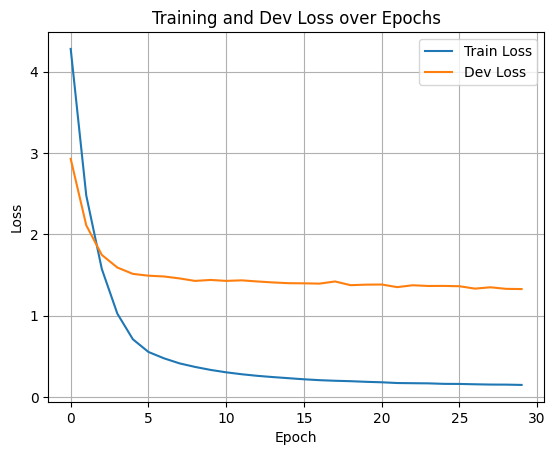


--- Evaluating BEST Bidirectional Attention Model on Dev Set ---

--- Loading Best Model for Fine-tuning ---
Loading best model weights from: best_bi_attn_model.pt

--- Fine-tuning with Lower Learning Rate ---
Starting training for up to 15 epochs...
Early stopping patience: 5 epochs. Saving best model to: fine_tuned_best_bi_attn_model.pt


/tmp/ipykernel_31/3421859032.py:155: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_fine_tune.load_state_dict(torch.load(best_model_save_path))


Epoch 1/15 | Train Loss: 0.1952 | Dev Loss: 1.2861 | Dev Loss Improved, Saving Model
Epoch 2/15 | Train Loss: 0.1149 | Dev Loss: 1.2773 | Dev Loss Improved, Saving Model
Epoch 3/15 | Train Loss: 0.0750 | Dev Loss: 1.2714 | Dev Loss Improved, Saving Model
Epoch 4/15 | Train Loss: 0.0524 | Dev Loss: 1.2790 | Patience Counter: 1/5
Epoch 5/15 | Train Loss: 0.0402 | Dev Loss: 1.2825 | Patience Counter: 2/5
Epoch 6/15 | Train Loss: 0.0342 | Dev Loss: 1.2815 | Patience Counter: 3/5
Epoch 7/15 | Train Loss: 0.0313 | Dev Loss: 1.2788 | Patience Counter: 4/5
Epoch 8/15 | Train Loss: 0.0299 | Dev Loss: 1.2890 | Patience Counter: 5/5
Early stopping triggered.
Training finished. Best Dev Loss: 1.2714

--- Evaluating FINE-TUNED Best Bidirectional Attention Model ---
Loading fine-tuned best model weights from: fine_tuned_best_bi_attn_model.pt
Running inference on development set (FINE-TUNED Best Bi-Attention Model with BEAM SEARCH)...


/tmp/ipykernel_31/3421859032.py:195: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_final_best.load_state_dict(torch.load(fine_tuned_best_model_save_path))


NameError: name 'dev_shuffled_sentences' is not defined

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import numpy as np # Needed for inf
import os # Needed for file path

# --- Training Function with Early Stopping, Gradient Clipping ---
# (Define this function if you haven't already, or modify your existing one)
def train_model_early_stopping(model, train_loader, dev_loader, optimizer, criterion, device, clip, patience, model_path, num_epochs=30):
    """Trains the model with early stopping based on dev loss."""
    model.to(device)
    train_losses = []
    dev_losses = []

    best_dev_loss = float('inf')
    patience_counter = 0

    print(f"Starting training for up to {num_epochs} epochs...")
    print(f"Early stopping patience: {patience} epochs. Saving best model to: {model_path}")

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0

        for src, trg in train_loader:
            src, trg = src.to(device), trg.to(device)

            optimizer.zero_grad()
            output = model(src, trg) # Forward pass

            output_flat = output.view(-1, output.shape[-1])
            trg_flat = trg.view(-1)

            loss = criterion(output_flat, trg_flat)
            loss.backward() # Calculate gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip) # Gradient Clipping
            optimizer.step() # Update weights
            epoch_train_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate on dev set
        model.eval()
        epoch_dev_loss = 0
        with torch.no_grad():
            for src, trg in dev_loader:
                src, trg = src.to(device), trg.to(device)
                output = model(src, trg)
                output_flat = output.view(-1, output.shape[-1])
                trg_flat = trg.view(-1)
                loss = criterion(output_flat, trg_flat)
                epoch_dev_loss += loss.item()

        avg_dev_loss = epoch_dev_loss / len(dev_loader)
        dev_losses.append(avg_dev_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Dev Loss: {avg_dev_loss:.4f}", end='')

        # Early Stopping Check
        if avg_dev_loss < best_dev_loss:
            best_dev_loss = avg_dev_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
            print(" | Dev Loss Improved, Saving Model")
        else:
            patience_counter += 1
            print(f" | Patience Counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break # Stop training

    print(f"Training finished. Best Dev Loss: {best_dev_loss:.4f}")
    # Ensure the function returns losses up to the point of stopping
    return train_losses, dev_losses

# --- Instantiate and Train Block ---

print("\n--- Training Seq2Seq Model with Bidirectional Encoder + Attention (Early Stopping) ---")

# 1. Define Hyperparameters
embedding_size = 128
hidden_size = 256   # Per direction for encoder, and decoder hidden size
encoder_layers = 2
decoder_layers = 2
max_epochs = 30      # Maximum epochs to run if no early stopping
learning_rate = 0.001
clip_value = 1.0     # Gradient clipping
dropout_prob = 0.4   # Increased dropout
weight_decay_val = 1e-5 # Added weight decay
early_stopping_patience = 5 # Stop after 5 epochs of no dev loss improvement
best_model_save_path = 'best_bi_attn_model.pt' # Path to save the best model

# Ensure these are defined from previous cells:
vocab_size = len(word2idx)
pad_idx = word2idx[PAD]
sos_idx = word2idx[SOS]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, dev_loader
# dev_df, word2idx, idx2word, max_len

# 2. Instantiate Models
encoder_bi_attn = EncoderRNN(vocab_size, embedding_size, hidden_size, num_layers=encoder_layers)
# Pass encoder_hidden_dim and dropout_p
decoder_bi_attn = DecoderRNN(vocab_size, embedding_size, hidden_size,
                             encoder_hidden_dim=hidden_size,
                             num_layers=decoder_layers,
                             dropout_p=dropout_prob) # Pass dropout here
model_bi_attn = Seq2SeqWithAttention(encoder_bi_attn, decoder_bi_attn, sos_idx, device)
model_bi_attn.to(device)

print(f"Bidirectional Attention model created on device: {device}")
print(f"Model Parameters: {sum(p.numel() for p in model_bi_attn.parameters() if p.requires_grad):,}")


# 3. Define Optimizer (with weight decay) and Criterion
optimizer_bi_attn = optim.Adam(model_bi_attn.parameters(), lr=learning_rate, weight_decay=weight_decay_val) # Added weight_decay
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)


# 4. Train the Bidirectional Attention Model with Early Stopping
train_losses_bi_attn, dev_losses_bi_attn = train_model_early_stopping(
    model_bi_attn, train_loader, dev_loader,
    optimizer_bi_attn, criterion, device, clip_value,
    patience=early_stopping_patience,
    model_path=best_model_save_path,
    num_epochs=max_epochs # Pass max epochs
)

# 5. Plot Losses
print("\nPlotting bidirectional attention model losses...")
# Make sure plot_losses function exists and can handle potentially fewer epochs due to early stopping
plot_losses(train_losses_bi_attn, dev_losses_bi_attn)


# --- Evaluation Block (Using BEST saved model) ---

print("\n--- Evaluating BEST Bidirectional Attention Model on Dev Set ---")

# --- BLOCK 1: Load the previously determined best model (Epoch 8) ---
print("\n--- Loading Best Model for Fine-tuning ---")
# Instantiate a new model instance
encoder_fine_tune = EncoderRNN(vocab_size, embedding_size, hidden_size, num_layers=encoder_layers)
decoder_fine_tune = DecoderRNN(vocab_size, embedding_size, hidden_size,
                               encoder_hidden_dim=hidden_size,
                               num_layers=decoder_layers,
                               dropout_p=dropout_prob)
model_fine_tune = Seq2SeqWithAttention(encoder_fine_tune, decoder_fine_tune, sos_idx, device)

best_model_save_path = 'best_bi_attn_model.pt' # Path where Epoch 8 model was saved
if os.path.exists(best_model_save_path):
    print(f"Loading best model weights from: {best_model_save_path}")
    model_fine_tune.load_state_dict(torch.load(best_model_save_path))
    model_fine_tune.to(device)
else:
    print(f"Error: Best model file not found at {best_model_save_path}. Cannot fine-tune.")

# --- BLOCK 2: Fine-tune with lower learning rate ---
print("\n--- Fine-tuning with Lower Learning Rate ---")

# Define new optimizer with lower LR and same weight decay
fine_tune_lr = 0.0001 # Significantly lower LR
optimizer_fine_tune = optim.Adam(model_fine_tune.parameters(), lr=fine_tune_lr, weight_decay=weight_decay_val)

# Define new save path for the fine-tuned best model
fine_tuned_best_model_save_path = 'fine_tuned_best_bi_attn_model.pt'
fine_tune_max_epochs = 15 # Train for up to 15 more epochs
fine_tune_patience = 5 # Reset patience for fine-tuning

# Ensure train_model_early_stopping function is defined
train_losses_fine_tune, dev_losses_fine_tune = train_model_early_stopping(
    model_fine_tune, train_loader, dev_loader,
    optimizer_fine_tune, criterion, device, clip_value, # Use same criterion/clip
    patience=fine_tune_patience,
    model_path=fine_tuned_best_model_save_path, # Save to new path
    num_epochs=fine_tune_max_epochs
)

# --- BLOCK 3: Evaluate the FINE-TUNED Best Model ---
print("\n--- Evaluating FINE-TUNED Best Bidirectional Attention Model ---")

# Instantiate final model instance
encoder_final = EncoderRNN(vocab_size, embedding_size, hidden_size, num_layers=encoder_layers)
decoder_final = DecoderRNN(vocab_size, embedding_size, hidden_size,
                           encoder_hidden_dim=hidden_size,
                           num_layers=decoder_layers,
                           dropout_p=dropout_prob)
model_final_best = Seq2SeqWithAttention(encoder_final, decoder_final, sos_idx, device)

# Load weights saved during fine-tuning
if os.path.exists(fine_tuned_best_model_save_path):
    print(f"Loading fine-tuned best model weights from: {fine_tuned_best_model_save_path}")
    model_final_best.load_state_dict(torch.load(fine_tuned_best_model_save_path))
    model_final_best.to(device)
else:
    print(f"Error: Fine-tuned best model file not found. Evaluating last state.")
    model_final_best = model_fine_tune # Evaluate the last state from fine-tuning

# Get dev sentences
# dev_shuffled_sentences = dev_df['input_sentence'].tolist()
# dev_target_sentences = dev_df['target_sentence'].tolist()

# Run inference using BEAM SEARCH
print("Running inference on development set (FINE-TUNED Best Bi-Attention Model with BEAM SEARCH)...")
model_final_best.eval()
beam_k = 10 # Use beam width 10 again
dev_predictions_final = infer_sentences_attention_beam(
    dev_shuffled_sentences,
    model_final_best,
    word2idx,
    idx2word,
    device,
    max_len,
    beam_width=beam_k
)
print(f"Inference complete (Beam Width = {beam_k}).")

# Evaluate the predictions
print("\nEvaluating dev set predictions (FINE-TUNED Best Bi-Attention Model with BEAM SEARCH):")
dev_accuracy_final = evaluate_sentence_predictions(dev_predictions_final, dev_target_sentences)

# Print samples
print("\nSample Dev Predictions vs Targets (FINE-TUNED Best Bi-Attention Model with BEAM SEARCH):")
for i in range(min(5, len(dev_predictions_final))):
    print(f"Input:    {dev_shuffled_sentences[i]}")
    print(f"Predicted: {dev_predictions_final[i]}")
    print(f"Target:   {dev_target_sentences[i]}")
    print("-" * 20)

print("--- FINE-TUNED Evaluation Finished ---")

In [17]:
dev_shuffled_sentences = dev_df['input_sentence'].tolist()
dev_target_sentences = dev_df['target_sentence'].tolist()
print("Running inference on development set (FINE-TUNED Best Bi-Attention Model with BEAM SEARCH)...")
model_final_best.eval()
beam_k = 10 # Use beam width 10 again
dev_predictions_final = infer_sentences_attention_beam(
    dev_shuffled_sentences,
    model_final_best,
    word2idx,
    idx2word,
    device,
    max_len,
    beam_width=beam_k
)
print(f"Inference complete (Beam Width = {beam_k}).")



Running inference on development set (FINE-TUNED Best Bi-Attention Model with BEAM SEARCH)...
Inference complete (Beam Width = 10).

Evaluating dev set predictions (FINE-TUNED Best Bi-Attention Model with BEAM SEARCH):
Exact match accuracy: 0.00%

Sample Dev Predictions vs Targets (FINE-TUNED Best Bi-Attention Model with BEAM SEARCH):
Input:    upset? What got him so
Predicted: what <UNK> him got up.
Target:   What got him so upset?
--------------------
Input:    planting neighbor grass his is yard. My in new
Predicted: my <UNK> <UNK> is sleeping in his son.
Target:   My neighbor is planting new grass in his yard.
--------------------
Input:    I It morning saw Mr. yesterday was Carter. that
Predicted: yesterday i saw it was a dangerous <UNK>
Target:   It was yesterday morning that I saw Mr. Carter.
--------------------
Input:    as clearly as can. you speak Please
Predicted: 
Target:   Please speak as clearly as you can.
--------------------
Input:    orange? have Can I this
Predicted

In [19]:
# Evaluate the predictions
print("\nEvaluating dev set predictions (FINE-TUNED Best Bi-Attention Model with BEAM SEARCH):")
dev_accuracy_final = evaluate_sentence_predictions(dev_predictions_final, dev_target_sentences)

# Print samples
print("\nSample Dev Predictions vs Targets (FINE-TUNED Best Bi-Attention Model with BEAM SEARCH):")
for i in range(min(5, len(dev_predictions_final))):
    print(f"Input:    {dev_shuffled_sentences[i]}")
    print(f"Predicted: {dev_predictions_final[i]}")
    print(f"Target:   {dev_target_sentences[i]}")
    print("-" * 20)

print("--- FINE-TUNED Evaluation Finished ---")


Evaluating dev set predictions (FINE-TUNED Best Bi-Attention Model with BEAM SEARCH):
Exact match accuracy: 6.37%

Sample Dev Predictions vs Targets (FINE-TUNED Best Bi-Attention Model with BEAM SEARCH):
Input:    upset? What got him so
Predicted: what <UNK> him got up.
Target:   What got him so upset?
--------------------
Input:    planting neighbor grass his is yard. My in new
Predicted: my <UNK> <UNK> is sleeping in his son.
Target:   My neighbor is planting new grass in his yard.
--------------------
Input:    I It morning saw Mr. yesterday was Carter. that
Predicted: yesterday i saw it was a dangerous <UNK>
Target:   It was yesterday morning that I saw Mr. Carter.
--------------------
Input:    as clearly as can. you speak Please
Predicted: 
Target:   Please speak as clearly as you can.
--------------------
Input:    orange? have Can I this
Predicted: i can have <UNK> <UNK>
Target:   Can I have this orange?
--------------------
--- FINE-TUNED Evaluation Finished ---


In [22]:
import os

# --- Step 1: Confirm Best Model File Location ---

# Define the path where the best fine-tuned model was saved
fine_tuned_best_model_save_path = 'fine_tuned_best_bi_attn_model.pt'
kaggle_output_dir = '/kaggle/working/' # Standard Kaggle output directory
model_full_path = os.path.join(kaggle_output_dir, fine_tuned_best_model_save_path)


print(f"\n--- Confirming Best Model Location ---")
if os.path.exists(model_full_path):
    # File is saved within the Kaggle environment
    print(f"Best model file is saved at: {model_full_path}")
    print("After committing the notebook, find this file in the 'Output' section.")
else:
    # Check the current directory just in case
    if os.path.exists(fine_tuned_best_model_save_path):
         model_full_path = os.path.abspath(fine_tuned_best_model_save_path)
         print(f"Best model file is saved at: {model_full_path}")
         print("After committing the notebook, find this file in the 'Output' section.")
    else:
        print(f"Error: Best model file '{fine_tuned_best_model_save_path}' not found in {kaggle_output_dir} or current dir.")


# --- Step 2: Generate Predictions for the Test Set ---

print(f"\n--- Generating Test Set Predictions using Best Model ---")

# Make sure the necessary variables are defined from previous cells:
# model_final_best (loaded with best weights), word2idx, idx2word, device, max_len
# And the inference function: infer_sentences_attention_beam

# Specify the beam width used for final predictions
final_beam_k = 10

# --- Load the actual test set ---
# Ensure test_no_target.csv is uploaded as a Kaggle Dataset or added to the notebook input
# Adjust path if necessary (e.g., /kaggle/input/your-dataset-name/test_no_target.csv)
test_set_path = '/kaggle/input/test-no-target/test_no_target.csv' # Check if this path is correct in Kaggle!
if os.path.exists(test_set_path):
    print(f"Loading test data from: {test_set_path}")
    test_df = pd.read_csv(test_set_path)
    test_shuffled_sentences = test_df['input_sentence'].tolist()

    # Ensure the final best model is loaded and on the correct device
    # (Should already be loaded in model_final_best from the evaluation block)
    model_final_best.to(device)
    model_final_best.eval() # Set to evaluation mode

    # Generate predictions using beam search
    print(f"Running inference on test set (Beam Width = {final_beam_k})...")
    test_predictions = infer_sentences_attention_beam(
        test_shuffled_sentences,
        model_final_best,
        word2idx,
        idx2word,
        device,
        max_len,
        beam_width=final_beam_k
    )
    print("Test set inference complete.")

    # --- Step 3: Save Predictions to CSV in Kaggle Output Directory ---
    # Define the full path within the /kaggle/working/ directory
    predictions_csv_filename = 'seq2seq_with_attention_predictions.csv'
    predictions_csv_path = os.path.join(kaggle_output_dir, predictions_csv_filename)

    print(f"Saving test predictions to: {predictions_csv_path}")

    # Create DataFrame
    predictions_df = pd.DataFrame({'predicted_sentence': test_predictions})

    # Save to CSV
    predictions_df.to_csv(predictions_csv_path, index=False)
    print("Predictions saved successfully.")
    print(f"Find '{predictions_csv_filename}' in the 'Output' section after committing.")

else:
    print(f"Error: Test set file '{test_set_path}' not found.")
    print("Please add 'test_no_target.csv' as input data to your Kaggle notebook.")

print("\n--- Process Complete ---")


--- Confirming Best Model Location ---
Best model file is saved at: /kaggle/working/fine_tuned_best_bi_attn_model.pt
After committing the notebook, find this file in the 'Output' section.

--- Generating Test Set Predictions using Best Model ---
Loading test data from: /kaggle/input/test-no-target/test_no_target.csv
Running inference on test set (Beam Width = 10)...
Test set inference complete.
Saving test predictions to: /kaggle/working/seq2seq_with_attention_predictions.csv
Predictions saved successfully.
Find 'seq2seq_with_attention_predictions.csv' in the 'Output' section after committing.

--- Process Complete ---


## 📌 Submission Instructions:
Submit your completed notebook along with two files of predictions over the test set - `seq2seq_predictions.csv` and `seq2seq_with_attention_predictions.csv`.

I will run the evaluation over the held-out test set.

You should email all of these files with an email specifying the names and ids of the team (couples).

✅ **Good luck!**
